Importing required modules

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np 
import itertools
import keras
from tensorflow import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential 
from keras import optimizers
import tensorflow as tf
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

Preparing input parameters

In [3]:
#Default dimensions we found online
img_width, img_height = 224, 224 
 
#Create a bottleneck file
top_model_weights_path = '/content/drive/MyDrive/WBC/model_for_taking_graph.h5'
# loading up our datasets
train_data_dir = "/content/drive/MyDrive/WBC/WBC/subtype classification/Train/Train" 
validation_data_dir = '/content/drive/MyDrive/WBC/WBC/subtype classification/TestA/TestA' 
test_data_dir = "/content/drive/MyDrive/WBC/WBC/subtype classification/TestA/TestA"
 
# number of epochs to train top model 
epochs = 7 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 50 

Loading the vgg19 module

In [4]:
#Loading vgc19 model
from tensorflow.keras.applications import VGG19 # VGG19
vgg_conv = VGG19(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

80150528/80134624 [==============================] - 0s 0us/step


Creation of the weights and feature using VGG19:

In [6]:
datagen = ImageDataGenerator(rescale=1. / 255) 
#needed to create the bottleneck .npy files

In [18]:
#__this can take an hour and half to run so only run it once. 
#once the npy files have been created, no need to run again. Convert this cell to a code cell to run.__
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = vgg_conv.predict_generator(generator, predict_size_train) 
 
np.save("/content/train_features.npy", bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 10175 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.


Time:  1:48:07.515085


Do the same for the validation data

In [19]:
#validation data
start = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_train_samples = len(generator.filenames) 
num_classes = len(generator.class_indices) 
 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 
 
bottleneck_features_train = vgg_conv.predict_generator(generator, predict_size_train) 
 
np.save("/validation_features.npy", bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start

Found 4386 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()


Creating a bottleneck file for the training data

In [20]:
#training data
generator_top = datagen.flow_from_directory( 
   train_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
train_data = np.load('/content/train_features.npy') 
 
# get the class labels for the training data, in the original order 
train_labels = generator_top.classes  
 
# convert the training labels to categorical vectors 
train_labels = to_categorical(train_labels, num_classes=num_classes)

Found 10175 images belonging to 5 classes.


In [21]:
train_labels.shape

(10175, 5)

Creating bottleneck file for validation data

In [22]:
#training data
generator_top = datagen.flow_from_directory( 
   validation_data_dir, 
   target_size=(img_width, img_height), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_train_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
# load the bottleneck features saved earlier 
validation_data = np.load('/validation_features.npy') 
 
# get the class labels for the training data, in the original order 
validation_labels = generator_top.classes  
 
# convert the training labels to categorical vectors 
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 4386 images belonging to 5 classes.


In [23]:
train_data.shape

(10175, 7, 7, 512)

In [25]:
validation_data.shape

(4386, 7, 7, 512)

In [14]:
#validation_data = np.reshape(validation_data,(4386,25088))

Creating our Convolutional Neural Network code:

In [26]:
start = datetime.datetime.now()
model = Sequential() 
model.add(Flatten(input_shape=train_data.shape[1:])) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))

In [27]:
model.compile(loss='categorical_crossentropy',
   optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
   metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [29]:
history = model.fit(train_data, train_labels,validation_data = (validation_data,validation_labels),epochs=7)

Epoch 1/7
318/318 [==============================] - 12s 37ms/step - loss: 0.3484 - acc: 0.8812 - val_loss: 0.2414 - val_acc: 0.9191
Epoch 2/7
318/318 [==============================] - 12s 37ms/step - loss: 0.2772 - acc: 0.9070 - val_loss: 0.2943 - val_acc: 0.9013
Epoch 3/7
318/318 [==============================] - 12s 37ms/step - loss: 0.2450 - acc: 0.9158 - val_loss: 0.2267 - val_acc: 0.9195
Epoch 4/7
318/318 [==============================] - 12s 38ms/step - loss: 0.2183 - acc: 0.9250 - val_loss: 0.2224 - val_acc: 0.9291
Epoch 5/7
318/318 [==============================] - 12s 37ms/step - loss: 0.2006 - acc: 0.9327 - val_loss: 0.2321 - val_acc: 0.9184
Epoch 6/7
318/318 [==============================] - 12s 37ms/step - loss: 0.1741 - acc: 0.9407 - val_loss: 0.2640 - val_acc: 0.9223
Epoch 7/7
318/318 [==============================] - 12s 38ms/step - loss: 0.1692 - acc: 0.9427 - val_loss: 0.2196 - val_acc: 0.9280


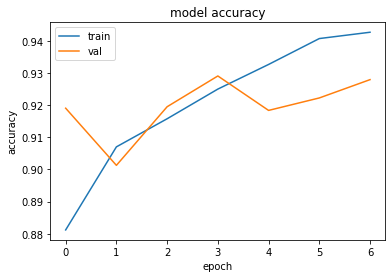

In [30]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

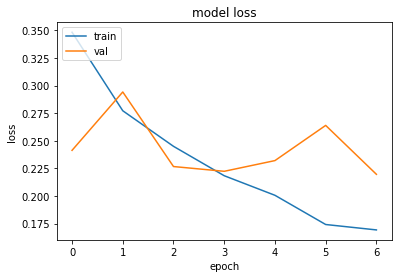

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [54]:
y_pred = model.predict(validation_data)

In [43]:
validation_labels

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [55]:
rounded = [np.round(x) for x in y_pred]

In [57]:
from  sklearn .metrics import classification_report,confusion_matrix
report=classification_report(validation_labels,rounded)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      0.99        89
           1       0.75      0.77      0.76       332
           2       0.98      0.94      0.96      1044
           3       0.89      0.43      0.58       234
           4       0.95      0.97      0.96      2687

   micro avg       0.94      0.92      0.93      4386
   macro avg       0.91      0.82      0.85      4386
weighted avg       0.94      0.92      0.93      4386
 samples avg       0.92      0.92      0.92      4386



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
rounded = np.asarray(rounded)

In [70]:
cm= confusion_matrix(
    validation_labels.argmax(axis=1), rounded.argmax(axis=1))
print(cm)

[[  89    0    0    0    0]
 [   9  257    8    1   57]
 [  29    8  979    9   19]
 [  28   31   10  101   64]
 [  16   47    6    3 2615]]


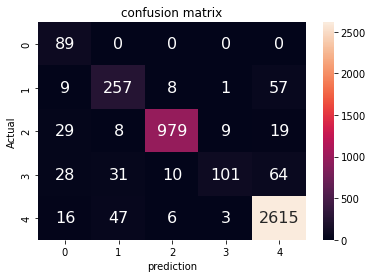

In [71]:
import seaborn 
seaborn .heatmap(cm, annot=True, annot_kws={"size": 16}, fmt='d')
plt.title('confusion matrix')
plt.xlabel('prediction')
plt.ylabel('Actual');

Save the model

In [ ]:
model.save_weights(top_model_weights_path)